In [1]:
# Peri 12/3/24 Used by Peri, in search of data to test these routines
# Molecule-Toxicity-Prediction
# This could serve as a baseline approach, but also to get familiar working with SMILES
# GIT https://github.com/nandarahul/Molecule-Toxicity-Prediction/tree/master
# Original author: Rahul Nanda PhD (Pharmacology & Toxicology ) at NIPER-R

#!pip install --user matplotlib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import ast
import torch
import torch.autograd as autograd
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import itertools
import matplotlib.pyplot as plt
from scipy import interp
from scipy import stats
import os

In [2]:
directory_path = 'C:/Users/kontoroupisp/OneDrive - TNO/Proposals/H-phrases and AI/Molecule-Toxicity-Prediction-master/Molecule-Toxicity-Prediction-master'
os.chdir(directory_path)
TRAIN_FILE_NAME = "train_molecule_new_features.csv"
TEST_FILE_NAME = "test_molecule_new_features.csv"


In [3]:
def read_train_data(filename):
    x = []
    y = []
    max_len = 0
    with open(filename) as infile:
        infile.readline()
        for line in infile:
            line = line.strip('\n\r ')
            line = line.split(",")
            y.append(line[len(line) - 1])
            fingerprint_bit_vector = list(map(int, line[12].strip()))
            line = line[1:12] + fingerprint_bit_vector
            max_len = max(max_len, len(line))
            x.append(line)
    print("max_len: {}".format(max_len))
    x = np.array(x)
    x = x.astype(float)
    y = np.array(y)
    y = y.astype(int)  # Fix here
    return x, y, max_len


In [4]:
def read_test_x(filename):
    x = []
    with open(filename) as infile:
        infile.readline()
        for line in infile:
            line = line.strip('\n\r ')
            line = line.split(",")
            fingerprint_bit_vector = list(map(int, line[12].strip()))
            line = line[0:12] + fingerprint_bit_vector
            x.append(line)
    x = np.array(x)
    x = x.astype(float)
    return x


In [5]:
class NeuralNetwork(object):
    def __init__(self, idim, odim, hdim1=1024, hdim2=1024):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(idim, hdim1),
            torch.nn.BatchNorm1d(hdim1),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(hdim1, hdim2),
            torch.nn.BatchNorm1d(hdim1),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(hdim2, odim),
            torch.nn.Softmax()
            )

    def nn_train(self, train_x, train_y, epoch, lrate):
        unique, counts = np.unique(train_y, return_counts=True)
        class_dist_dict = dict(zip(unique, counts))
        scale_pos_weight = class_dist_dict[0] * 1.0 / class_dist_dict[1]
        loss_fn = torch.nn.NLLLoss(weight=torch.FloatTensor([1, scale_pos_weight]))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate)

        X = autograd.Variable(torch.from_numpy(train_x), requires_grad=True).float()
        Y = autograd.Variable(torch.from_numpy(train_y), requires_grad=False).long()

        for itr in range(epoch):
            y_pred = self.model(X)
            loss = loss_fn(y_pred, Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def nn_test_prediction(self, test_x):
        X = autograd.Variable(torch.from_numpy(test_x), requires_grad=False).float()
        y_pred = self.model(X)
        return y_pred.data.numpy()[:, 1]



In [6]:
def tune_logistic(train_x, train_y, test_x, test_y):
    parameters = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 200]}

    max_auc = 0
    best_clf_dict = dict(C=None)
    for candidate_C in parameters['C']:
        logistic_clf = linear_model.LogisticRegression(penalty='l2', C=candidate_C, class_weight='balanced')
        logistic_clf.fit(train_x, train_y)
        auc = roc_auc_score(test_y, logistic_clf.predict_proba(test_x)[:, 1])
        if auc > max_auc:
            max_auc = auc
            best_clf_dict['C'] = candidate_C
    return best_clf_dict




In [7]:
def tune_xgb(train_x, train_y, test_x, test_y):
    unique, counts = np.unique(train_y, return_counts=True)
    class_dist_dict = dict(zip(unique, counts))
    scale_pos_weight = class_dist_dict[0]*1.0/class_dist_dict[1]
    parameters = {'learning_rate': list(np.arange(0.05, 0.2, 0.05)), 'max_depth': [2, 3, 4, 5]}

    max_auc = 0
    best_clf_dict = dict(learning_rate=None, max_depth=None)
    for candidate_lr in parameters['learning_rate']:
        for candidate_max_depth in parameters['max_depth']:
            #print(candidate_lr, candidate_max_depth)
            bst = XGBClassifier(max_depth=candidate_max_depth, scale_pos_weight=scale_pos_weight,
                                learning_rate=candidate_lr)
            bst.fit(train_x, train_y)
            auc = roc_auc_score(test_y, bst.predict_proba(test_x)[:, 1])
            if auc > max_auc:
                max_auc = auc
                best_clf_dict['learning_rate'], best_clf_dict['max_depth'] = candidate_lr, candidate_max_depth
    return best_clf_dict

In [8]:
def tune_nn(train_x, train_y, test_x, test_y):
    idim = train_x.shape[1]  # input dimension
    odim = 2  # output dimension
    parameters = {'learning_rate': [0.0005, 0.001, 0.005], 'epochs': [10, 15, 20, 30]}

    max_auc = 0
    best_clf_dict = dict(learning_rate=None)
    for candidate_lr in parameters['learning_rate']:
        for candidate_epoch in parameters['epochs']:
            NN = NeuralNetwork(idim=idim, odim=odim)
            NN.nn_train(train_x, train_y, candidate_epoch, candidate_lr)
            auc = roc_auc_score(test_y, NN.nn_test_prediction(test_x))
            if auc > max_auc:
                max_auc = auc
                #print(candidate_lr, candidate_epoch, auc)
                best_clf_dict['learning_rate'], best_clf_dict['epochs'] = candidate_lr, candidate_epoch
    return best_clf_dict


In [9]:
def tune_rf(train_x, train_y, test_x, test_y):
    parameters = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]}
    max_auc = 0
    best_clf_dict = dict(max_depth=None)
    for candidate_max_depth in parameters['max_depth']:
        rf_clf = RandomForestClassifier(n_estimators=500, max_depth=candidate_max_depth, oob_score=True,
                                        class_weight='balanced')
        rf_clf.fit(train_x, train_y)
        auc = roc_auc_score(test_y, rf_clf.predict_proba(test_x)[:, 1])
        if auc > max_auc:
            max_auc = auc
            best_clf_dict['max_depth'] = candidate_max_depth
    return best_clf_dict

In [10]:
def parameter_tuning(train_x, train_y):
    kf = StratifiedKFold(n_splits=2)
    auc_scores = dict(lr=[], xgb=[], nn=[], rf=[])
    for fold_num, (train_indices, test_indices) in enumerate(kf.split(train_x, train_y)):
        print("Fold: {}".format(fold_num))
        train_fold_x, train_fold_y = train_x[train_indices], train_y[train_indices]
        test_fold_x, test_fold_y = train_x[test_indices], train_y[test_indices]
        sub_train_x, sub_test_x, sub_train_y, sub_test_y = train_test_split(train_fold_x,
                                                                            train_fold_y,
                                                                            random_state=42,
                                                                            test_size=0.2, stratify=train_fold_y)
        tuned_lr_dict = tune_logistic(sub_train_x, sub_train_y, sub_test_x, sub_test_y)
        tuned_xgb_dict = tune_xgb(sub_train_x, sub_train_y, sub_test_x, sub_test_y)
        tuned_nn_dict = tune_nn(sub_train_x, sub_train_y, sub_test_x, sub_test_y)
        tuned_rf_dict = tune_rf(sub_train_x, sub_train_y, sub_test_x, sub_test_y)

        # Now train the best models on the original k-1 training folds
        logistic_clf = linear_model.LogisticRegression(penalty='l2', C=tuned_lr_dict['C'], class_weight='balanced')
        logistic_clf.fit(train_fold_x, train_fold_y)
        auc_scores['lr'].append((roc_auc_score(test_fold_y, logistic_clf.predict_proba(test_fold_x)[:, 1]), tuned_lr_dict))

        unique, counts = np.unique(train_fold_y, return_counts=True)
        class_dist_dict = dict(zip(unique, counts))
        scale_pos_weight = class_dist_dict[0] * 1.0 / class_dist_dict[1]
        xgb_clf = XGBClassifier(max_depth=tuned_xgb_dict['max_depth'], scale_pos_weight=scale_pos_weight,
                                learning_rate=tuned_xgb_dict['learning_rate'])
        xgb_clf.fit(train_fold_x, train_fold_y)
        auc_scores['xgb'].append((roc_auc_score(test_fold_y, xgb_clf.predict_proba(test_fold_x)[:, 1]), tuned_xgb_dict))

        NN = NeuralNetwork(idim=train_x.shape[1], odim=2)
        NN.nn_train(train_fold_x, train_fold_y, tuned_nn_dict['epochs'], tuned_nn_dict['learning_rate'])
        auc_scores['nn'].append((roc_auc_score(test_fold_y, NN.nn_test_prediction(test_fold_x)), tuned_nn_dict))


        rf_clf = RandomForestClassifier(n_estimators=500, max_depth=tuned_rf_dict['max_depth'], oob_score=True,
                                        class_weight='balanced')
        rf_clf.fit(train_fold_x, train_fold_y)
        auc_scores['rf'].append((roc_auc_score(test_fold_y, rf_clf.predict_proba(test_fold_x)[:, 1]), tuned_rf_dict))

        print("Logistic Regression: {}".format(auc_scores['lr'][fold_num]))
        print("Gradient Boosted Decision Tree: {}".format(auc_scores['xgb'][fold_num]))
        print("Neural Network: {}".format(auc_scores['nn'][fold_num]))
        print("Random Forest: {}".format(auc_scores['rf'][fold_num]))

    print(auc_scores)
    tuned_params = dict(lr=None, xgb=None, nn=[], rf=None)
    for key in auc_scores.keys():
        tuned_params[key] = max(auc_scores[key])[1]
    return tuned_params


In [11]:
def find_best_model(train_x, train_y, tuned_params):
    kf = StratifiedKFold(n_splits=10)
    auc_scores = dict(lr=[], xgb=[], nn=[], rf=[])
    for fold_num, (train_indices, test_indices) in enumerate(kf.split(train_x, train_y)):
        print(fold_num)
        train_fold_x, train_fold_y = train_x[train_indices], train_y[train_indices]
        test_fold_x, test_fold_y = train_x[test_indices], train_y[test_indices]

        logistic_clf = linear_model.LogisticRegression(penalty='l2', C=tuned_params['lr']['C'], class_weight='balanced')
        logistic_clf.fit(train_fold_x, train_fold_y)
        auc_scores['lr'].append(
            roc_auc_score(test_fold_y, logistic_clf.predict_proba(test_fold_x)[:, 1]))

        unique, counts = np.unique(train_fold_y, return_counts=True)
        class_dist_dict = dict(zip(unique, counts))
        scale_pos_weight = class_dist_dict[0] * 1.0 / class_dist_dict[1]
        xgb_clf = XGBClassifier(max_depth=tuned_params['xgb']['max_depth'], scale_pos_weight=scale_pos_weight,
                                learning_rate=tuned_params['xgb']['learning_rate'])
        xgb_clf.fit(train_fold_x, train_fold_y)
        auc_scores['xgb'].append(roc_auc_score(test_fold_y, xgb_clf.predict_proba(test_fold_x)[:, 1]))

        NN = NeuralNetwork(idim=train_fold_x.shape[1], odim=2)
        NN.nn_train(train_fold_x, train_fold_y, tuned_params['nn']['epochs'], tuned_params['nn']['learning_rate'])
        auc_scores['nn'].append(roc_auc_score(test_fold_y, NN.nn_test_prediction(test_fold_x)))

        rf_clf = RandomForestClassifier(n_estimators=500, max_depth=tuned_params['rf']['max_depth'], oob_score=True,
                                        class_weight='balanced')
        rf_clf.fit(train_fold_x, train_fold_y)
        auc_scores['rf'].append(roc_auc_score(test_fold_y, rf_clf.predict_proba(test_fold_x)[:, 1]))

    tstat1, p1 = stats.ttest_rel(auc_scores['rf'], auc_scores['xgb'])
    tstat2, p2 = stats.ttest_rel(auc_scores['rf'], auc_scores['nn'])
    tstat3, p3 = stats.ttest_rel(auc_scores['rf'], auc_scores['lr'])

    return tstat1, p1, tstat2, p2, tstat3, p3

In [12]:
def plot_learning_curves(train_x, train_y, tuned_params):
    unique, counts = np.unique(train_y, return_counts=True)
    class_dist_dict = dict(zip(unique, counts))
    scale_pos_weight = class_dist_dict[0] * 1.0 / class_dist_dict[1]
    training_size_ratio = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
    sub_train_x, sub_test_x, sub_train_y, sub_test_y = train_test_split(train_x,
                                                                        train_y,
                                                                        test_size=0.3,
                                                                        stratify=train_y)
    title_dict = {'lr': 'Logistic Regression', 'xgb': 'Gradient Boosted Decision Tree', 'rf': 'Random Forest',
                  'nn': 'Neural Network'}
    for key in tuned_params:
        auc_scores_training, auc_scores_validation = [], []
        if key == 'lr':
            clf = linear_model.LogisticRegression(penalty='l2', C=tuned_params['lr']['C'],
                                                  class_weight='balanced')
        elif key == 'xgb':
            clf = XGBClassifier(max_depth=tuned_params['xgb']['max_depth'], scale_pos_weight=scale_pos_weight,
                                learning_rate=tuned_params['xgb']['learning_rate'])
        elif key == 'rf':
            clf = RandomForestClassifier(n_estimators=500, max_depth=tuned_params['rf']['max_depth'], oob_score=True,
                                         class_weight='balanced')
        for tsr in training_size_ratio:
            small_train_x = sub_train_x[:int(tsr * len(sub_train_x))]
            small_train_y = sub_train_y[:int(tsr * len(sub_train_y))]
            if key == 'nn':
                NN = NeuralNetwork(idim=small_train_x.shape[1], odim=2)
                NN.nn_train(small_train_x, small_train_y, epoch=tuned_params['nn']['epochs'],
                            lrate=tuned_params['nn']['learning_rate'])
                auc_scores_training.append(roc_auc_score(small_train_y, NN.nn_test_prediction(small_train_x)))
                auc_scores_validation.append(roc_auc_score(sub_test_y, NN.nn_test_prediction(sub_test_x)))
            else:
                clf.fit(small_train_x, small_train_y)
                auc_scores_training.append(roc_auc_score(small_train_y, clf.predict_proba(small_train_x)[:, 1]))
                auc_scores_validation.append(roc_auc_score(sub_test_y, clf.predict_proba(sub_test_x)[:, 1]))

        fig = plt.figure()
        plt.plot(training_size_ratio, auc_scores_validation, 'ro-', label='Testing AUC')
        plt.plot(training_size_ratio, auc_scores_training, 'bo-', label='Training AUC')
        plt.legend()
        plt.ylim(0)
        plt.xticks(training_size_ratio)
        plt.xlabel('Training size')
        plt.ylabel('AUC score')
        plt.title(title_dict[key])
        plt.show()
        plt.close(fig)


In [13]:
def plot_roc_curves(train_x, train_y, tuned_params):
    title_dict = {'lr': 'Logistic Regression', 'xgb': 'Gradient Boosted Decision Tree', 'rf': 'Random Forest',
                  'nn': 'Neural Network'}
    for key in tuned_params:
        if key == 'lr':
            classifier = linear_model.LogisticRegression(penalty='l2', C=tuned_params['lr']['C'],
                                                         class_weight='balanced')
        elif key == 'xgb':
            unique, counts = np.unique(train_y, return_counts=True)
            class_dist_dict = dict(zip(unique, counts))
            scale_pos_weight = class_dist_dict[0] * 1.0 / class_dist_dict[1]
            classifier = XGBClassifier(max_depth=tuned_params['xgb']['max_depth'], scale_pos_weight=scale_pos_weight,
                                learning_rate=tuned_params['xgb']['learning_rate'])
        elif key == 'rf':
            classifier = RandomForestClassifier(n_estimators=500, max_depth=tuned_params['rf']['max_depth'], oob_score=True,
                                                class_weight='balanced')
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        i = 0
        kf = StratifiedKFold(n_splits=10)
        for fold_num, (train_indices, test_indices) in enumerate(kf.split(train_x, train_y)):
            print(fold_num)
            train_fold_x, train_fold_y = train_x[train_indices], train_y[train_indices]
            test_fold_x, test_fold_y = train_x[test_indices], train_y[test_indices]
            if key == 'nn':
                NN = NeuralNetwork(idim=train_fold_x.shape[1], odim=2)
                NN.nn_train(train_fold_x, train_fold_y, tuned_params['nn']['epochs'], tuned_params['nn']['learning_rate'])
                probas_ = NN.nn_test_prediction(test_fold_x)
            else:
                probas_ = classifier.fit(train_fold_x, train_fold_y).predict_proba(test_fold_x)[:, 1]
            # Compute ROC curve and area under the curve
            fpr, tpr, thresholds = roc_curve(test_fold_y, probas_)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1

        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                 label='Random Classifier(Base)', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic ' + title_dict[key])
        plt.legend(loc="lower right")
        plt.show()


In [14]:
def main():
    train_x, train_y, max_len = read_train_data(TRAIN_FILE_NAME)
    train_x[np.isnan(train_x)] = 0
    test_x = read_test_x(TEST_FILE_NAME)
    test_indices = test_x[:, 0]
    std_scale = preprocessing.MinMaxScaler().fit(train_x)
    train_x = std_scale.transform(train_x)
    test_x = std_scale.transform(test_x[:, 1:])
    unique, counts = np.unique(train_y, return_counts=True)
    class_dist_dict = dict(zip(unique, counts))
    # print(class_dist_dict)
    #tuned_params = parameter_tuning(train_x, train_y)
    #print(tuned_params)
    # This is the dictionary of best hyper-parameters obtained after tuning
    tuned_params = {'lr': {'C': 0.05}, 'xgb': {'learning_rate': 0.1, 'max_depth': 2}, 'rf': {'max_depth': 9},
                    'nn': {'epochs': 10, 'learning_rate': 0.001}}

    # tuned_params = {'nn': {'epochs': 13, 'learning_rate': 0.002}}
    
    # plot_learning_curves(train_x, train_y, tuned_params)
    plot_roc_curves(train_x, train_y, tuned_params)
    # find_best_model(train_x, train_y, tuned_params)



max_len: 2059
0


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


1


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


2


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


3


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


4


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


5


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


6


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


7


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


8


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


9


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


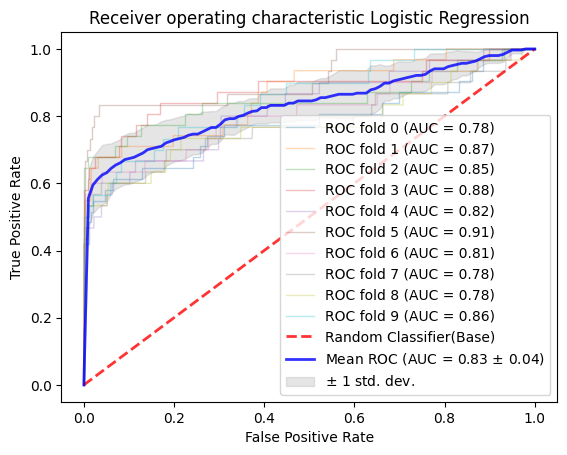

0


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


1


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


2


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


3


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


4


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


5


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


6


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


7


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


8


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


9


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


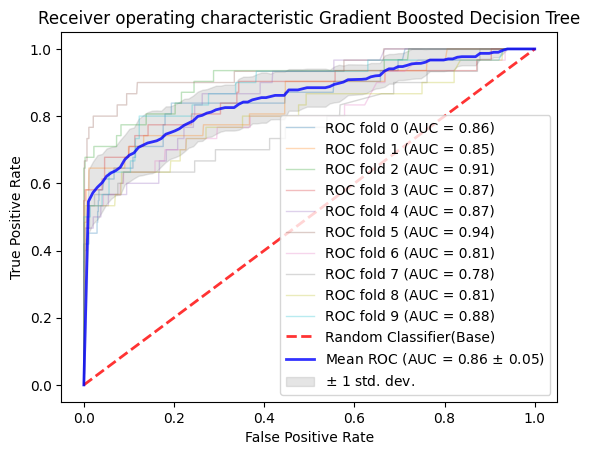

0


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


1


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


2


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


3


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


4


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


5


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


6


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


7


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


8


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


9


C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


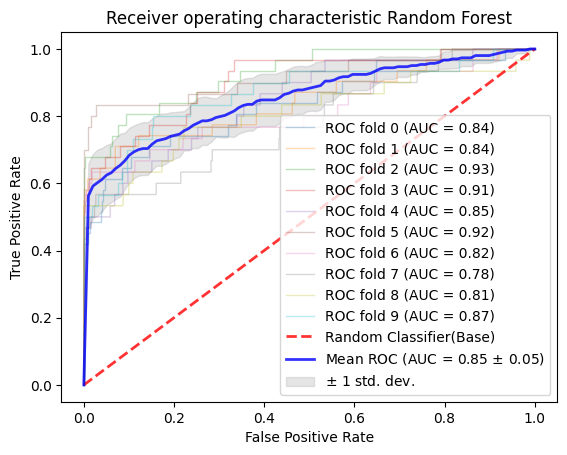

0


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


1


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


2


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


3


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


4


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


5


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


6


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


7


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


8


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


9


C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\kontoroupisp\AppData\Local\Temp\ipykernel_20368\2408430892.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


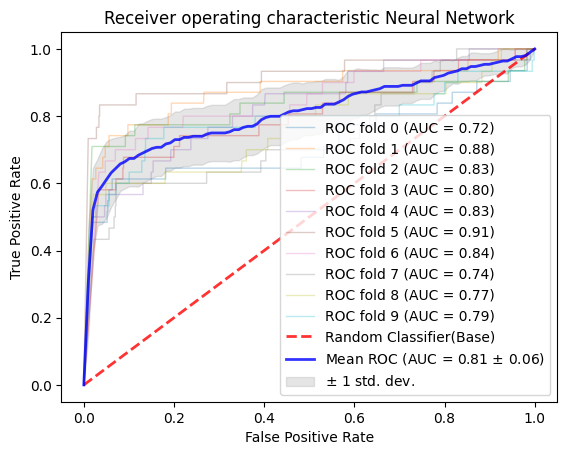

In [15]:
main()
